# Getting started

Thanks for checking out GAINS! 

We'll walk through the simplest usage cases for the engine module.

## The engine module

GAINS operates using the simplified molecular-input line-entry system ([SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)). We use this to create the molecular structures ([Chromosome](https://wesleybeckner.github.io/gains/gains.html#gains.engine.Chromosome) objects) to be manipulated by the engine. 

Let's explore the simple case of creating butane from propanol:

In [1]:
import gains as genetic
import numpy as np

target = "CCCC" #butane smiles
parent_candidates = np.array(["CCCO"]) #propanol smiles, numpy array

In order to begin manipulating the parent_candidate we have to, at a minimum, define three additional functions to interact with the engine: a fitness function, and two display functions; one for displaying accepted mutations one for displaying the final result. 

The fitness function is the most important user-defined function to interact with the engine, so we'll start there. It allows us to plug any desired objective into the engine; whether it be a quantitative structure property relationship (QSPR), an acitivity/toxicity score, or, as in this case, a simple similarity mapping between a target and a starting structure:

In [2]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import AllChem as Chem

def get_fitness(genes, target):
    ms = [Chem.MolFromSmiles(target), Chem.MolFromSmiles(genes)]
    fps = [FingerprintMols.FingerprintMol(x) for x in ms]
    return DataStructs.FingerprintSimilarity(fps[0], fps[1]), None

You can read more of RDKit's documentation on molecular fingerprint similarity [here](http://www.rdkit.org/docs/GettingStartedInPython.html#fingerprinting-and-molecular-similarity). Briefly, the fingerprinting algorithm identifies and hashes topological paths in the molecule before folding them down to a set density of bits. We exploit this in the engine to give us a fitness score for a candidate we are attempting to mutate towards the target structure.

The engine doesn't need to know anything about the target since the fitness function is defined on the user end. To avoid passing the target to and from the engine (and taking up cpu time) we define a helper function:

In [3]:
def fnGetFitness(genes):
    return get_fitness(genes, target)

This brings us to the last two functions we need to define, the display functions. There is a lot of freedom here to choose what we would like to print to the screen. At a minimum, the engine expects to pass the candidate (Chromosome object) and the current mutation to the display function; and the candidate's genes (SMILES string), target (int, float, or array), count of the mutation attempts (int), and two additional variables we'll get into later (the similarity score and corresponding molecular relative to the molecular solution) to the result display function.

In the following I've chosen to print the mutation performed, the fitness score, and the SMILES of the candidate in the display function and the number of atoms and number of mutations in the result display function:

In [5]:
def display(candidate, mutation):
    print("{:>20}{:>15}{:>15}".format(mutation, "{:3.4f}".
                                  format(candidate.Fitness),
                                  candidate.Genes))

    
def result_display(genes, target, mutation_attempts, sim_score,
             molecular_relative):
    mol = Chem.MolFromSmiles(genes)
    print("{:>20}{:>15}".format("number of atoms:", mol.GetNumAtoms()))
    print("{:>20}{:>15}".format("mutation attempts:", mutation_attempts))

We have just two more items to pass to the engine: the geneSet object and the optimal fitness we are searching for.

The geneSet object contains the atoms and fragments the engine is allowed to use in any mutation attempt. For now these are hard coded into the engine and may be viewed [here](https://wesleybeckner.github.io/gains/gains.html#gains.engine.GeneSet).

The optimal fitness in our case is 1 (perfect mapping between candidate and target). But to be thorough we set this by passing the fitness score between the target and itself:

In [7]:
geneSet = genetic.generate_geneset()
optimalFitness, prediction = get_fitness(target, target)

We're now ready to put this all together:

In [8]:
best = genetic.get_best(fnGetFitness, optimalFitness, geneSet,
                        display, result_display, target,
                        parent_candidates)

  starting structure         0.3333           CCCO
 add_custom_fragment         0.3529         CCCCCO
         remove_atom         0.4615          CCCCO
         remove_atom         1.0000           CCCC
    number of atoms:              4
  mutation attempts:             34


In this simple example it took 34 mutation attempt to get from "CCCO" (propanol) to "CCCC" (butane); only 3 of which were accepted because they resulted in a higher fitness score than the candidate being mutated.

In the next section we'll go over the different mutations available to the engine.

## The mutate function

the GAINS engine can perform the following mutations to a molecular candidate:

* remove_atom
* add_atom
* replace_atom
* add_custom_fragment
* remove_custom_fragment
* add_rdkit_fragment
* remove_rdkit_fragment

To understand these sub functions, it is illustrative to look at the [function](https://wesleybeckner.github.io/gains/_modules/gains/engine.html#generate_geneset) that generates the geneSet:

```
    atoms = [6, 7, 8, 9, 5, 15, 16, 17]
    fName = os.path.join(RDConfig.RDDataDir, 'FunctionalGroups.txt')
    rdkitFrags = FragmentCatalog.FragCatParams(1, 5, fName)
    customFrags = FragmentCatalog.FragCatalog(rdkitFrags)
    fcgen = FragmentCatalog.FragCatGenerator()
    m = Chem.MolFromSmiles('CCCC')
    fcgen.AddFragsFromMol(m, customFrags)
    return GeneSet(atoms, rdkitFrags, customFrags)
```

`atoms` is set according to atomic number: carbon, nitrogen, oxygen, fluorine, boron, phosphorus, sulfur, and chlorine. 

`rdkitFrags` is best understood by showing the output from rdkit itself:

In [1]:
from rdkit import RDConfig
from rdkit.Chem import FragmentCatalog
import os
fName = os.path.join(RDConfig.RDDataDir, 'FunctionalGroups.txt')
rdkitFrags = FragmentCatalog.FragCatParams(1, 5, fName)
rdkitFrags.GetNumFuncGroups()

39

The engine is utilizing 39 built-in fragments from RDKit. We can view these fragments individually:

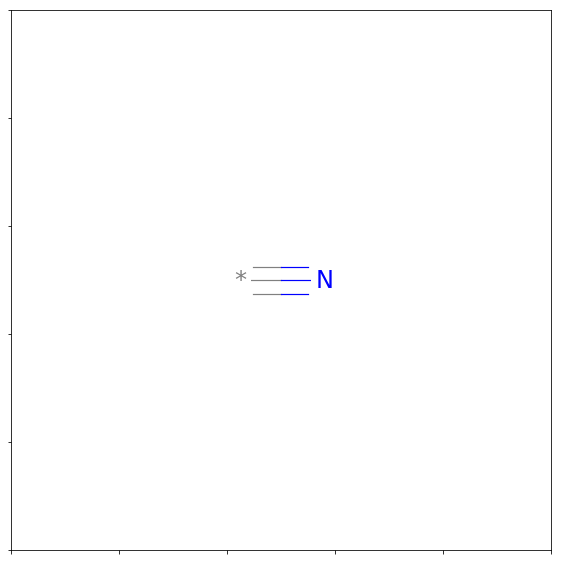

In [2]:
from rdkit.Chem import Draw
Draw.MolToMPL(rdkitFrags.GetFuncGroup(38))

and view all of their smiles strings:

In [4]:
from rdkit import Chem
for i in range(0,rdkitFrags.GetNumFuncGroups()):
    print(Chem.MolToSmiles(rdkitFrags.GetFuncGroup(i)))

[*]NC(C)=O
[*]C(=O)O
[*]C(=O)OC
[*]C(C)=O
[*]C(N)=O
[*]C(C)=O
[*]N=C=O
[*]N=C=S
[*]N(=O)O
[*]N=O
[*]=NO
[*]=NC
[*]N=C
[*]N=NC
[*]N=N
[*]N#N
[*]C#N
[*]S(N)(=O)=O
[*]NS(C)(=O)=O
[*]S(=O)(=O)O
[*]S(=O)(=O)OC
[*]S(C)(=O)=O
[*]S(=O)(=O)Cl
[*]S(C)=O
[*]SC
[*]S
[*]=S
[*]F
[*]C(C)(C)C
[*]C(F)(F)F
[*]C#C
[*]C1CC1
[*]OCC
[*]OC
[*]O
[*]=O
[*]N
[*]=N
[*]#N


You can learn more about RDKit fragments [here](http://www.rdkit.org/docs/GettingStartedInPython.html#molecular-fragments). The customFrags will change in future versions of GAINS. For now they are simply substructures of butane:

In [8]:
fName = os.path.join(RDConfig.RDDataDir, 'FunctionalGroups.txt')
rdkitFrags = FragmentCatalog.FragCatParams(1, 5, fName)
customFrags = FragmentCatalog.FragCatalog(rdkitFrags)
fcgen = FragmentCatalog.FragCatGenerator()
m = Chem.MolFromSmiles('CCCC')
fcgen.AddFragsFromMol(m, customFrags)
for i in range(3):
    print(customFrags.GetEntryDescription(i))

CC
CCC
CCCC


We've covered the important information you need to know to get up and running with GAINS. In the next chapter of the series we'll go over more complex fitness and display functions to take full advantage of the package. For convenience here is the full code of minimal functions we've described for interacting with the engine module:

In [9]:
import gains as genetic
import numpy as np
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import AllChem as Chem

target = "CCCC" #butane smiles
parent_candidates = np.array(["CCCO"]) #propanol smiles, numpy array

def get_fitness(genes, target):
    ms = [Chem.MolFromSmiles(target), Chem.MolFromSmiles(genes)]
    fps = [FingerprintMols.FingerprintMol(x) for x in ms]
    return DataStructs.FingerprintSimilarity(fps[0], fps[1]), None

def fnGetFitness(genes):
    return get_fitness(genes, target)

def display(candidate, mutation):
    print("{:>20}{:>15}{:>15}".format(mutation, "{:3.4f}".
                                  format(candidate.Fitness),
                                  candidate.Genes))

def result_display(genes, target, mutation_attempts, sim_score,
             molecular_relative):
    mol = Chem.MolFromSmiles(genes)
    print("{:>20}{:>15}".format("number of atoms:", mol.GetNumAtoms()))
    print("{:>20}{:>15}".format("mutation attempts:", mutation_attempts))
    
geneSet = genetic.generate_geneset()
optimalFitness, prediction = get_fitness(target, target)
best = genetic.get_best(fnGetFitness, optimalFitness, geneSet,
                        display, result_display, target,
                        parent_candidates)

  starting structure         0.3333           CCCO
         remove_atom         0.6667            CCC
 add_custom_fragment         0.7500          CCCCC
         remove_atom         1.0000           CCCC
    number of atoms:              4
  mutation attempts:             41
